<a href="https://colab.research.google.com/github/yingzibu/ODE/blob/main/learn/nonmem/eta_eps_gradient_descent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

previously use scipy.optimize, did not have a good result. Use gradient descent to see


## First simulate some data, using one-compartment IV

### Simulation data did not consider outliers. If those exist, not sure which one is more stable.

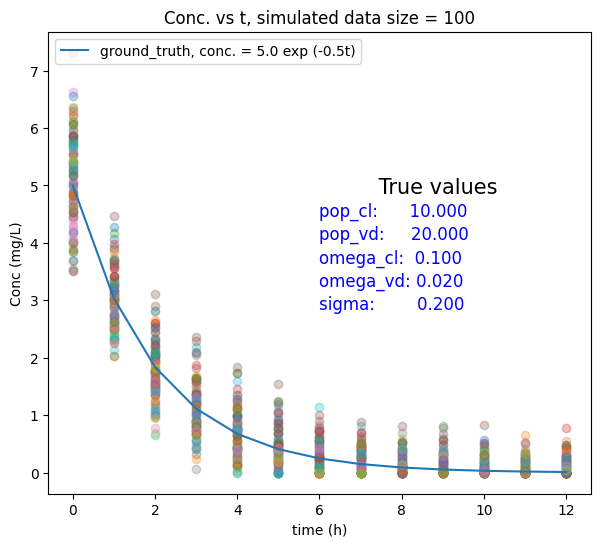

In [67]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy.optimize import minimize
import matplotlib
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
from torch.utils import data
from tqdm import tqdm
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
matplotlib.rcParams['figure.figsize'] = (3.5*2, 6)

np.random.seed(42)
n_patients = 100
n_obs = 13
max_t = n_obs-1
dose = 100
# Population parameters
pop_cl = 10.0  # Population clearance
pop_vd = 20.0  # Population volume

# Variance of random effects (eta)
omg_cl = 0.1  # Variance for clearance
omg_vd = 0.02   # Variance for volume

sigma = 0.2
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Simulate data
data = []
min_conc = np.float64(0) # minimal concentration possible is 0
for patient in range(n_patients):
    eta_cl = np.random.normal(0, np.sqrt(omg_cl)) # Random effect of clearance
    eta_vd = np.random.normal(0, np.sqrt(omg_vd))   # Random effect for volume

    for t in range(n_obs):
        time = t  # Time in hours
        # Simple PK model: C(t) = Dose / V * e^(-Cl/V * t)
        ind_v = pop_vd * np.exp(eta_vd)
        ind_cl = pop_cl * np.exp(eta_cl)
        concentration = (dose / ind_v) * np.exp(-ind_cl / ind_v * time)
        # print(concentration)
        # print(type(concentration))
        # break

        # Add some observation error
        concentration += np.random.normal(0, sigma)  # Adding Gaussian noise

        # the min concentration should be 0
        if concentration < min_conc: concentration = min_conc

        data.append([patient, time, concentration])

# Convert to DataFrame
df = pd.DataFrame(data, columns=['patient', 'time', 'concentration'])
for patient in df['patient'].unique():
    patient_data = df[df['patient'] == patient]
    if n_patients <=20:
        plt.scatter(patient_data['time'], patient_data['concentration'],
                label=f'Patient {patient}', alpha=0.7)
    else: plt.scatter(patient_data['time'], patient_data['concentration'], alpha=0.3)

true_conc = [dose / pop_vd * np.exp(-pop_cl / pop_vd * t) for t in range(n_obs)]
plt.plot(range(n_obs), true_conc,
         label=f'ground_truth, conc. = {dose/pop_vd} exp (-{pop_cl/pop_vd}t)')

plt.annotate(f'         True values ',
            xy=(0.5, 0.65), xycoords='axes fraction', fontsize=15, color='black')

plt.annotate(f'pop_cl:      {pop_cl:.3f}',
            xy=(0.5, 0.6), xycoords='axes fraction', fontsize=12, color='blue')
plt.annotate(f'pop_vd:     {pop_vd:.3f}',
            xy=(0.5, 0.55), xycoords='axes fraction', fontsize=12, color='blue')

plt.annotate(f'omega_cl:  {omg_cl:.3f}',
            xy=(0.5, 0.5), xycoords='axes fraction', fontsize=12, color='blue')
plt.annotate(f'omega_vd: {omg_vd:.3f}',
            xy=(0.5, 0.45), xycoords='axes fraction', fontsize=12, color='blue')

plt.annotate(f'sigma:        {sigma:.3f}',
            xy=(0.5, 0.4), xycoords='axes fraction', fontsize=12, color='blue')
plt.legend(loc=2)
plt.xlabel('time (h)'); plt.ylabel('Conc (mg/L)')
plt.title(f'Conc. vs t, simulated data size = {n_patients}')
plt.show(); plt.close()


## First estimate a global, in this case CL and Vd


### Use greadient descent and neural network to optimize CL and Vd

Use patient data without considering the difference for person.

In [13]:
class global_estimation(nn.Module):
    def __init__(self):
        super().__init__()
        self.vd = torch.nn.Parameter(torch.tensor(0.1))
        self.cl = torch.nn.Parameter(torch.tensor(0.1))
        self.device = device
    def forward(self, t, Dose=dose):
        conc = Dose/self.vd * torch.exp(-self.cl/self.vd * t)
        return conc.to(self.device)


In [14]:
from torch.utils import data
t = torch.tensor(df.time.tolist()).to(device)
y = torch.tensor(df.concentration.tolist()).to(device)
dataset = data.TensorDataset(t, y)
loader = data.DataLoader(dataset, batch_size=64, shuffle=True)
# for i,j in loader:
#      print(i, j)
#      break

  5%|▍         | 9999/200000 [06:22<2:09:03, 24.54it/s]

Epoch: 10000, Loss: 0.292
Vd(20.0): 19.538, Cl(10.0): 9.798


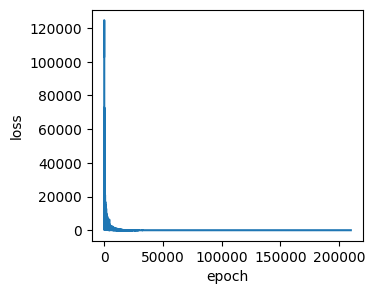

  5%|▌         | 10623/200000 [06:45<2:00:35, 26.17it/s]

early stop


In [16]:
model = global_estimation().to(device)
opt = optim.AdamW(model.parameters())
loss_fn = nn.MSELoss()
loss_all = []
min_loss = np.inf; min_epoc = 0
MAX_EPOCH = 200000
model_path_ = 'test.pt'
verbose_freq = 5000
patience = 5000
matplotlib.rcParams['figure.figsize'] = (3.5, 3)

for epoch in tqdm(range(MAX_EPOCH), total=MAX_EPOCH):
    model.train()
    for inp, out in loader:
        # print(inp.shape, out.shape)
        opt.zero_grad()
        loss = loss_fn(model(inp), out)
        loss.backward()
        opt.step()
        for p in model.parameters(): p.data.clamp_(min=0.0)
        loss_all.append(loss.item())
    if loss.item() < min_loss:
        min_loss = loss.item()
        min_epoch = epoch
        torch.save(model.state_dict(), model_path_)
    if epoch - min_epoch > patience: print('early stop'); break

    if epoch % verbose_freq == 0 and epoch >= verbose_freq:
        print(f'Epoch: {epoch}, Loss: {loss:.3f}');
        print(f'Vd({pop_vd}): {model.vd.item():.3f}, Cl({pop_cl}): {model.cl.item():.3f}')
        plt.plot(loss_all);
        plt.xlabel('epoch'); plt.ylabel('loss')
        plt.show(); plt.close()

In [17]:
import warnings
# Ignore only FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

def load_model(model, path, device='cpu'):
    print('load model from path: ', path)
    model.load_state_dict(torch.load(path, map_location=device))

load_model(model, model_path_)
print(f'Vd true | pred: {pop_vd} | {model.vd.item():.3f}')
print(f'Cl true | pred: {pop_cl} | {model.cl.item():.3f}')
print('\n')

model.eval()
pred_list = []
inp_list = []
oup_list = []
for inp, oup in loader:
    inp_list += inp.detach().cpu().numpy().tolist()
    oup_list += oup.detach().cpu().numpy().tolist()
    pred = model(inp)
    pred_list += pred.detach().cpu().numpy().tolist()

load model from path:  test.pt
Vd true | pred: 20.0 | 19.524
Cl true | pred: 10.0 | 9.784




vd(20.0): 19.524, cl(10.0): 9.784


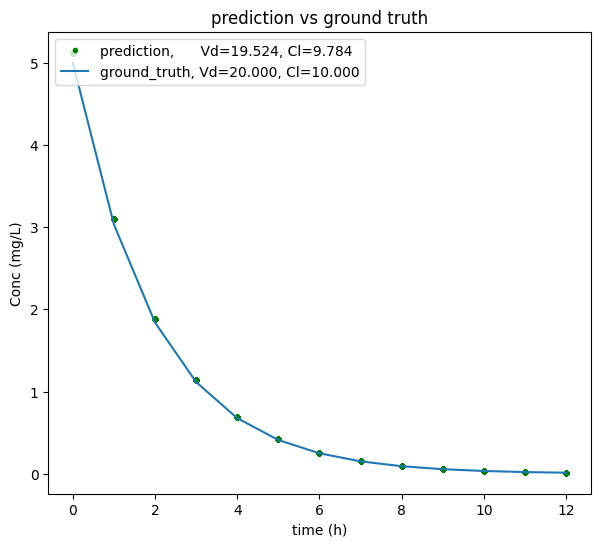

In [41]:
pred_vd = model.vd.item()
pred_cl = model.cl.item()

print(f'vd({pop_vd}): {pred_vd:.3f}, cl({pop_cl}): {pred_cl:.3f}')

matplotlib.rcParams['figure.figsize'] = (3.5*2, 6)
plt.plot(inp_list, pred_list, 'go',
         label=f'prediction,      Vd={pred_vd:.3f}, Cl={pred_cl:.3f}',
         markersize=3)

plt.plot(range(n_obs), true_conc,
         label=f'ground_truth, Vd={pop_vd:.3f}, Cl={pop_cl:.3f}')
# plt.plot(time_here, conc_time(time_here), label='ground truth')
plt.xlabel('time (h)')
plt.ylabel('Conc (mg/L)')
plt.title('prediction vs ground truth')
plt.legend(loc=2)
plt.show()

In [42]:
class pk_dataset(Dataset):
    def __init__(self, df):
        self.df = df
        self.patient_ids = df['patient'].unique()

    def __len__(self): return len(self.patient_ids)

    def __getitem__(self, idx, device=device):
        try: assert idx in self.patient_ids
        except: print(f'{idx} not find in data'); return

        patient_data = self.df[self.df['patient'] == idx]
        time = torch.tensor(patient_data.time.tolist()).to(device)
        conc = torch.tensor(patient_data.concentration.tolist()).to(device)

        return idx, time, conc

dataset = pk_dataset(df)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
for batch in dataloader:
    patient_ids, t, obs = batch
    print("Patient IDs:", patient_ids)
    print("Times:", t)
    print("Concentrations:", obs)
    break

Patient IDs: tensor([66])
Times: tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]], device='cuda:0')
Concentrations: tensor([[6.6243, 3.1354, 1.4037, 0.7302, 0.7451, 0.3172, 0.0000, 0.1599, 0.3021,
         0.1958, 0.0173, 0.0000, 0.1409]], device='cuda:0')


In [43]:
class NNTest(nn.Module):
    def __init__(self, n_patients=n_patients, device=device,
                 pred_cl=None, pred_vd=None, train_pop=True):
        super().__init__()
        self.device = device
        self.n_patients = n_patients

        # Population-level parameters (learnable)
        if pop_cl != None:
            if train_pop:
                self.pop_cl = torch.nn.Parameter(torch.tensor(pred_cl))  # Pop clearance
            else: self.pop_cl = pred_cl # do not train this parameter
        else: self.pop_cl = torch.nn.Parameter(torch.tensor(0.1))

        if pop_vd != None:
            if train_pop:
                self.pop_vd = torch.nn.Parameter(torch.tensor(pred_vd))  # Pop clearance
            else: self.pop_vd = pred_vd # do not train this parameter
        else: self.pop_vd = torch.nn.Parameter(torch.tensor(0.1))


        # Variances for the random effects (initiation)
        # will be updated using self.eta_cl and self.eta_vd
        self.omg_cl = torch.tensor(0.1)
        self.omg_vd = torch.tensor(0.1)

        # Residual error (sigma, learnable)
        self.sigma = torch.nn.Parameter(torch.tensor(0.1))  # Residual error (sigma)

        # Patient-specific random effects (eta), one per patient (constant across all time points)
        self.eta_cl = torch.nn.Parameter(# Eta for clearance for each patient
            torch.normal(0, torch.sqrt(self.omg_cl), size=(n_patients,)))
        self.eta_vd = torch.nn.Parameter(# Eta for volume for each patient
            torch.normal(0, torch.sqrt(self.omg_vd), size=(n_patients,)))

    def update_omg(self):
        self.omg_vd = torch.var(self.eta_vd, unbiased=False).detach()
        self.omg_cl = torch.var(self.eta_cl, unbiased=False).detach()

    def forward(self, t, patient_idx, Dose=100):
        # Get the patient-specific eta values (constant across all time points for the patient)
        eta_cl_patient = self.eta_cl[patient_idx]  # Eta for clearance for the patient
        eta_vd_patient = self.eta_vd[patient_idx]  # Eta for volume for the patient

        # Calculate individual clearance and volume for the patient
        ind_cl = self.pop_cl * torch.exp(eta_cl_patient)
        ind_vd = self.pop_vd * torch.exp(eta_vd_patient)

        # Predict concentration for this patient
        pred = (Dose / ind_vd) * torch.exp(-ind_cl / ind_vd * t)

        return pred


## NLL: negative log-likelihood

$\text{NLL} = \sum \left[\frac{(y_{obs}- y_{pred})^2}{2\sigma^2} + \log (\sigma \sqrt{2\pi})\right]$

In [50]:
def plot_pred_vs_true(idx, t, observed, pred, epoch=None):
    plt.plot(t.cpu().numpy().tolist()[0], observed.cpu().numpy().tolist()[0], '.',
             t.cpu().numpy().tolist()[0], pred.detach().cpu().numpy().tolist()[0], '--g')
    if epoch == None: # this is evaluation
        title_here = f'Conc vs t, patient {idx.item()}'
    else:
        title_here = f'Conc vs t, patient {idx.item()}, at epoch {epoch}'
    plt.title(title_here)

    plt.xlabel('time (h)'); plt.ylabel('Conc. (mg/L)'); plt.legend(['true', 'pred']);
    plt.annotate(f'           Pred | True ',
                xy=(0.5, 0.55), xycoords='axes fraction', fontsize=10, color='black')

    plt.annotate(f'pop_cl:   {model_pop_cl:.3f} | {pop_cl:.3f}',
                xy=(0.5, 0.5), xycoords='axes fraction', fontsize=8, color='blue')
    plt.annotate(f'pop_vd:  {model_pop_vd:.3f} | {pop_vd:.3f}',
                xy=(0.5, 0.45), xycoords='axes fraction', fontsize=8, color='blue')
    plt.annotate(f'sigma:   {model.sigma.item():.3f} | {sigma:.3f}',
                xy=(0.5, 0.4), xycoords='axes fraction', fontsize=8, color='blue')
    plt.annotate(f'eta_cl:   {model.eta_cl[idx].item():.3f} | ',
                xy=(0.5, 0.35), xycoords='axes fraction', fontsize=8, color='blue')
    plt.annotate(f'eta_vd:  {model.eta_vd[idx].item():.3f} |',
                xy=(0.5, 0.3), xycoords='axes fraction', fontsize=8, color='blue')
    plt.show(); plt.close()

def nll_loss(model, t, observed_data, patient_idx, Dose=100):
    # Get predictions from the model for a specific patient
    pred = model(t, patient_idx, Dose)
    # Residual error (sigma)
    sigma = model.sigma + 1e-8 # add stability

    # Compute the negative log-likelihood (NLL)
    nll = (observed_data - pred) ** 2 / (2 * sigma ** 2) \
            + torch.log(sigma * torch.sqrt(torch.tensor(2 * torch.pi,
                                                        device=model.device)))

    return torch.mean(nll)

## We used the fixed pop PK parameters trained before. Do not update Cl and Vd

fixed pop_cl and pop_vd, will not update during training


training:   0%|          | 1000/1000000 [03:31<58:26:19,  4.75it/s]


Epoch 1000, Total Loss: -0.387
	 pop_cl | pop_vd | omg_cl | omg_vd | sigma
True 	 10.000    20.000    0.100    0.020    0.200
Pred 	 9.784    19.524    0.071    0.025    0.164


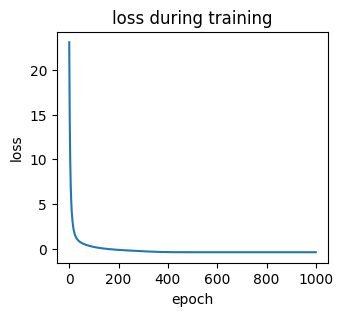

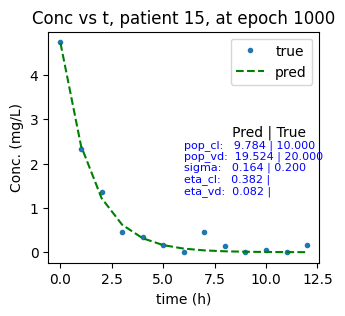

training:   0%|          | 2000/1000000 [07:02<58:55:41,  4.70it/s]


Epoch 2000, Total Loss: -0.387
	 pop_cl | pop_vd | omg_cl | omg_vd | sigma
True 	 10.000    20.000    0.100    0.020    0.200
Pred 	 9.784    19.524    0.071    0.025    0.164


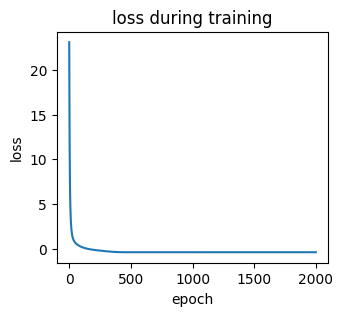

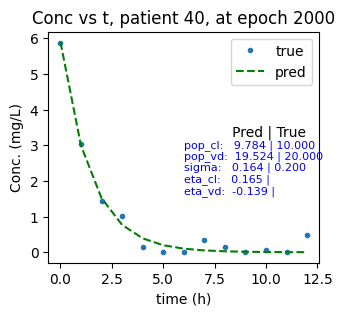

training:   0%|          | 2737/1000000 [09:37<58:28:34,  4.74it/s]

early stop


In [56]:
# do no train the pop parameters that was already estimated
train_pop = False
print('fixed pop_cl and pop_vd, will not update during training')

model = NNTest(pred_cl=pred_cl, pred_vd=pred_vd, train_pop=train_pop).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.01, weight_decay=1e-3)
model_path_var = 'test_.pt'

num_epochs = 1000000
min_loss = np.inf
min_epoch = 0
loss_list = []
matplotlib.rcParams['figure.figsize'] = (3.5, 3)
patience_here = 1000

for epoch in tqdm(range(num_epochs), total=num_epochs, desc='training'):
    model.train()
    optimizer.zero_grad()

    total_loss = 0

    for batch in dataloader:
        idx, t, observed = batch
        loss = nll_loss(model, t, observed, idx)
        total_loss += loss
    total_loss /= len(dataloader)
    model.update_omg()
    loss_list.append(total_loss.item())


    # Backpropagation and optimization
    total_loss.backward()
    optimizer.step()
    if total_loss.item() < min_loss:
        min_loss = total_loss.item()
        min_epoch = epoch
        torch.save(model.state_dict(), model_path_var)

    if epoch - min_epoch > patience_here:
        print('early stop'); break
    # for p in model.parameters(): p.data.clamp_(min=0)

    if epoch % 1000 == 0 and epoch > 100:
        model.eval()

        with torch.no_grad():
            try: model_pop_cl = model.pop_cl.item()
            except: model_pop_cl = model.pop_cl
            try: model_pop_vd = model.pop_vd.item()
            except: model_pop_vd = model.pop_vd
            print(f'\nEpoch {epoch}, Total Loss: {total_loss.item():.3f}')

            print('\t pop_cl | pop_vd | omg_cl | omg_vd | sigma')
            print(f'True \t {pop_cl:.3f}    {pop_vd:.3f}    {omg_cl:.3f}    {omg_vd:.3f}    {sigma:.3f}')
            print(f'Pred \t {model_pop_cl:.3f}    {model_pop_vd:.3f}',
                end = "    ")
            print(f'{model.omg_cl.item():.3f}    {model.omg_vd.item():.3f}    {model.sigma.item():.3f}')
            # print(epoch)
            if epoch > 100:
                plt.plot([i for i in range(epoch+1)], loss_list)
                plt.xlabel('epoch'); plt.ylabel('loss'); plt.title('loss during training')
                plt.show();plt.close()

            pred = model(t, idx, Dose=100)
            plot_pred_vs_true(idx, t, observed, pred, epoch=epoch)

load model from path:  test_.pt
Total Loss: -0.387
	 pop_cl | pop_vd | omg_cl | omg_vd | sigma
True 	 10.000    20.000    0.100    0.020    0.200
Pred 	 9.784    19.524    0.071    0.025    0.164



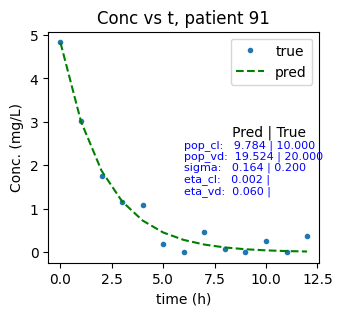

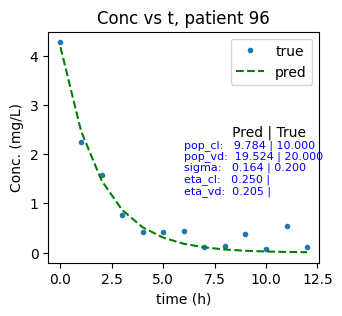

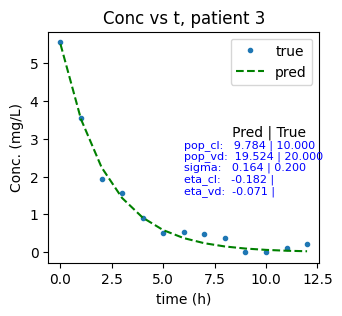

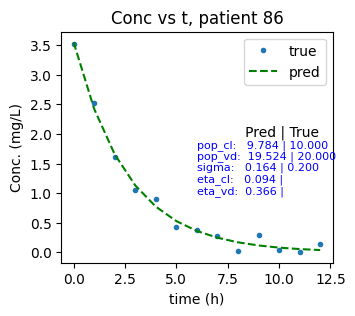

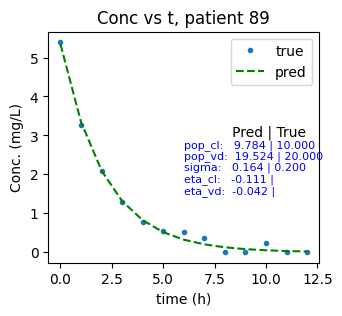

In [57]:
load_model(model, model_path_var)
model.eval()
print(f'Total Loss: {total_loss.item():.3f}')
print('\t pop_cl | pop_vd | omg_cl | omg_vd | sigma')
print(f'True \t {pop_cl:.3f}    {pop_vd:.3f}    {omg_cl:.3f}    {omg_vd:.3f}    {sigma:.3f}')
print(f'Pred \t {model_pop_cl:.3f}    {model_pop_vd:.3f}',
    end = "    ")
print(f'{model.omg_cl.item():.3f}    {model.omg_vd.item():.3f}    {model.sigma.item():.3f}')
print()
for i, batch in enumerate(dataloader):
    if i < 5:
        idx, t, observed = batch
        with torch.no_grad():
            pred = model(t, idx, Dose=100)
            plot_pred_vs_true(idx, t, observed, pred)

In [58]:
pop_cl_pred = model_pop_cl
pop_v_pred = model_pop_vd
omega_cl_pred = model.omg_cl.item()
omega_v_pred = model.omg_vd.item()
sigma_pred = model.sigma.item()

nn_no_train_pop = [pop_cl_pred, pop_v_pred, omega_cl_pred, omega_v_pred, sigma_pred]
print('neural network (gradient descent), did not train pop PK:')
nn_no_train_pop

neural network (gradient descent), did not train pop PK:


[9.784329414367676,
 19.52392578125,
 0.07076115906238556,
 0.02519012987613678,
 0.16424719989299774]

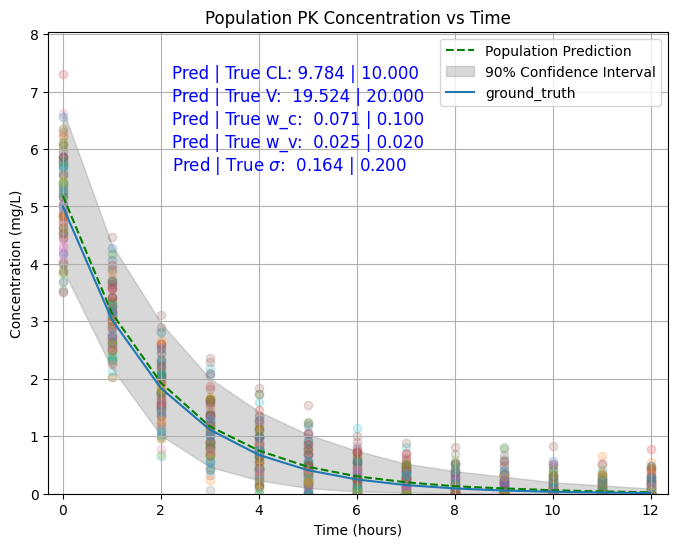

In [59]:
import seaborn as sns
# Create a time vector for predictions
time_vector = np.linspace(0, max_t, 100)

# Define the population-level PK model and generate predictions
def generate_population_predictions(time_points, pop_cl, pop_v, omega_cl, omega_v):
    pop_predictions = []
    ci_lower = []
    ci_upper = []

    for time in time_points:
        # Simulate the random effects for the population
        eta_cl = np.random.normal(0, np.sqrt(omega_cl), size=1000)  # Draw random effects for clearance
        eta_v = np.random.normal(0, np.sqrt(omega_v), size=1000)    # Draw random effects for volume

        # Population prediction with random effects
        preds = (100 / (pop_v * np.exp(eta_v))) * np.exp(
                        -((pop_cl * np.exp(eta_cl)) / (pop_v)) * time)

        # Calculate the mean prediction for the population
        mean_pred = np.mean(preds)
        pop_predictions.append(mean_pred)

        # Calculate the 90% confidence interval (based on the 5th and 95th percentiles)
        ci_lower.append(np.percentile(preds, 5))
        ci_upper.append(np.percentile(preds, 95))

    return pop_predictions, ci_lower, ci_upper


def plot_CI(param_list:list):
    pop_cl_pred = param_list[0]
    pop_v_pred =  param_list[1]
    omega_cl_pred = param_list[2]
    omega_v_pred =  param_list[3]
    sigma_pred =  param_list[4]
    # Generate the population predictions and 90% confidence intervals
    time_points = np.arange(n_obs)

    pop_predictions, ci_lower, ci_upper = generate_population_predictions(
                time_points, pop_cl_pred, pop_v_pred, omega_cl_pred, omega_v_pred)

    plt.figure(figsize=(8, 6))

    plt.plot(time_points, pop_predictions, '--g', label='Population Prediction')
    plt.fill_between(time_points, ci_lower, ci_upper,
                    color='grey', alpha=0.3, label='90% Confidence Interval')

    # Plot individual patient data
    for patient in df['patient'].unique():
        patient_data = df[df['patient'] == patient]
        plt.scatter(patient_data['time'], patient_data['concentration'],
                    alpha=0.2)

    plt.plot(range(n_obs), true_conc, label='ground_truth')
    plt.title('Population PK Concentration vs Time')
    plt.xlabel('Time (hours)')
    plt.ylabel('Concentration (mg/L)')
    plt.annotate(f'Pred | True CL: {pop_cl_pred:.3f} | {pop_cl:.3f}', xy=(0.2, 0.9),
                xycoords='axes fraction', fontsize=12, color='blue')
    plt.annotate(f'Pred | True V:  {pop_v_pred:.3f} | {pop_vd:.3f}', xy=(0.2, 0.85),
                xycoords='axes fraction', fontsize=12, color='blue')
    plt.annotate(f'Pred | True w_c:  {omega_cl_pred:.3f} | {omg_cl:.3f}',
                xy=(0.2, 0.8), xycoords='axes fraction', fontsize=12, color='blue')
    plt.annotate(f'Pred | True w_v:  {omega_v_pred:.3f} | {omg_vd:.3f}',
                xy=(0.2, 0.75), xycoords='axes fraction', fontsize=12, color='blue')
    plt.annotate(f'Pred | True $\sigma$:  {sigma_pred:.3f} | {sigma:.3f}',
                xy=(0.2, 0.7), xycoords='axes fraction', fontsize=12, color='blue')

    plt.legend(); plt.grid()
    plt.xlim(-0.3, max_t*1.03)
    plt.ylim([0, df['concentration'].max()*1.1])
    plt.show(); plt.close()

plot_CI(nn_no_train_pop)

# Actually we could also train pop parameters while training eta and eps

trainable pop_cl and pop_vd


training:   0%|          | 0/1000000 [00:00<?, ?it/s]

Epoch 0, Total Loss: 29.415
	 pop_cl | pop_vd | omg_cl | omg_vd | sigma
True 	 10.000    20.000    0.100    0.020    0.200
Pred 	 9.794    19.534    0.117    0.123    0.110


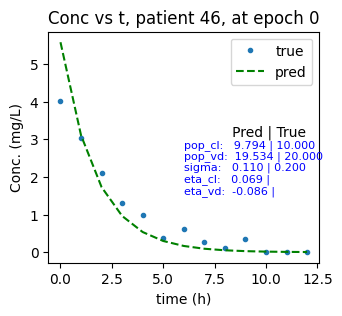

training:   0%|          | 3000/1000000 [10:47<58:41:34,  4.72it/s]

Epoch 3000, Total Loss: -0.387
	 pop_cl | pop_vd | omg_cl | omg_vd | sigma
True 	 10.000    20.000    0.100    0.020    0.200
Pred 	 9.897    19.565    0.071    0.025    0.164


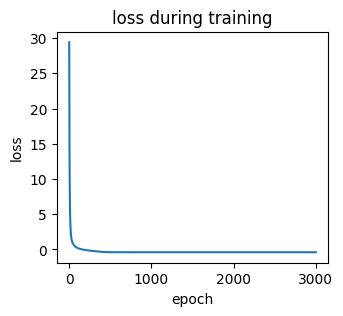

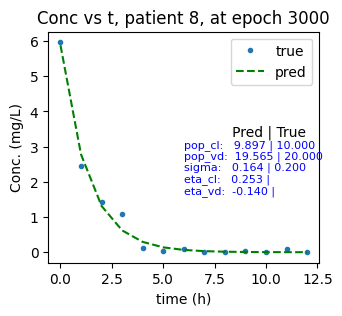

training:   1%|          | 5847/1000000 [21:00<59:31:49,  4.64it/s]

early stop


In [60]:
# train the pop parameters that was already estimated
train_pop = True
print('trainable pop_cl and pop_vd')
model = NNTest(pred_cl=pred_cl, pred_vd=pred_vd, train_pop=train_pop).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.01, weight_decay=1e-3)

model_path_var_train_pop = 'test_train_pop.pt'
# Training loop
num_epochs = 1000000
min_loss = np.inf
min_epoch = 0
loss_list = []
matplotlib.rcParams['figure.figsize'] = (3.5, 3)
patience_here = 3000

for epoch in tqdm(range(num_epochs), total=num_epochs, desc='training'):
    model.train()
    optimizer.zero_grad()

    total_loss = 0

    for batch in dataloader:
        idx, t, observed = batch
        loss = nll_loss(model, t, observed, idx)
        total_loss += loss
    total_loss /= len(dataloader)
    model.update_omg()
    loss_list.append(total_loss.item())

    # Backpropagation and optimization
    total_loss.backward()
    optimizer.step()
    if total_loss.item() < min_loss:
        min_loss = total_loss.item()
        min_epoch = epoch
        torch.save(model.state_dict(), model_path_var_train_pop)

    if epoch - min_epoch > patience_here: print('early stop'); break
    # for p in model.parameters(): p.data.clamp_(min=0)

    if epoch % 3000 == 0:
        model.eval()

        with torch.no_grad():
            try: model_pop_cl = model.pop_cl.item()
            except: model_pop_cl = model.pop_cl
            try: model_pop_vd = model.pop_vd.item()
            except: model_pop_vd = model.pop_vd
            print(f'Epoch {epoch}, Total Loss: {total_loss.item():.3f}')

            print('\t pop_cl | pop_vd | omg_cl | omg_vd | sigma')
            print(f'True \t {pop_cl:.3f}    {pop_vd:.3f}    {omg_cl:.3f}    {omg_vd:.3f}    {sigma:.3f}')
            print(f'Pred \t {model_pop_cl:.3f}    {model_pop_vd:.3f}',
                end = "    ")
            print(f'{model.omg_cl.item():.3f}    {model.omg_vd.item():.3f}    {model.sigma.item():.3f}')
            # print(epoch)
            if epoch > 100:
                plt.plot([i for i in range(epoch+1)], loss_list)
                plt.xlabel('epoch'); plt.ylabel('loss'); plt.title('loss during training')
                plt.show();plt.close()

            pred = model(t, idx, Dose=100)
            plot_pred_vs_true(idx, t, observed, pred, epoch=epoch)

load model from path:  test_train_pop.pt
Total Loss: -0.387
	 pop_cl | pop_vd | omg_cl | omg_vd | sigma
True 	 10.000    20.000    0.100    0.020    0.200
Pred 	 9.897    19.565    0.071    0.025    0.164

Demonstrate 5 curves


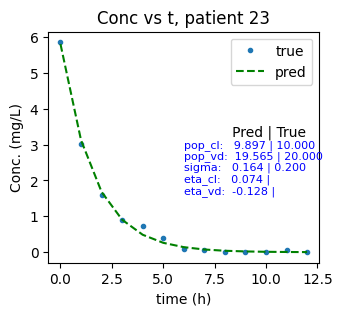

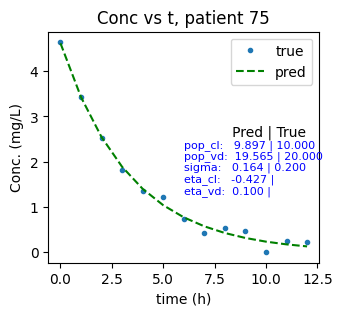

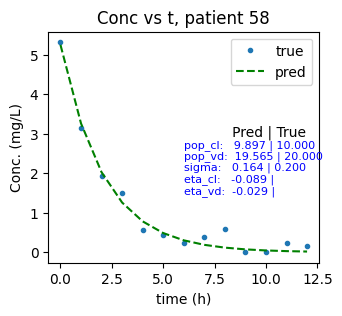

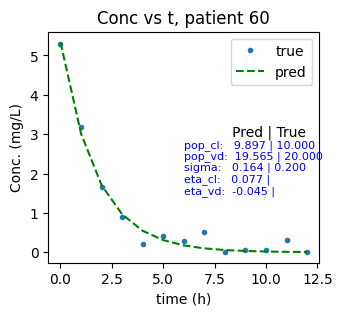

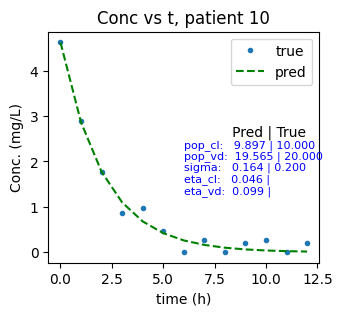

In [61]:
load_model(model, model_path_var_train_pop)
model.eval()
print(f'Total Loss: {total_loss.item():.3f}')
print('\t pop_cl | pop_vd | omg_cl | omg_vd | sigma')
print(f'True \t {pop_cl:.3f}    {pop_vd:.3f}    {omg_cl:.3f}    {omg_vd:.3f}    {sigma:.3f}')
print(f'Pred \t {model_pop_cl:.3f}    {model_pop_vd:.3f}',
    end = "    ")
print(f'{model.omg_cl.item():.3f}    {model.omg_vd.item():.3f}    {model.sigma.item():.3f}')
print()
print('Demonstrate 5 curves')
for i, batch in enumerate(dataloader):
    if i < 5:
        idx, t, observed = batch
        with torch.no_grad():
            pred = model(t, idx, Dose=100)
            plot_pred_vs_true(idx, t, observed, pred)

In [62]:
pop_cl_pred = model_pop_cl
pop_v_pred = model_pop_vd
omega_cl_pred = model.omg_cl.item()
omega_v_pred = model.omg_vd.item()
sigma_pred = model.sigma.item()

nn_train_pop = [pop_cl_pred, pop_v_pred, omega_cl_pred, omega_v_pred, sigma_pred]
print('neural network (gradient descent), train pop PK:')
nn_train_pop

neural network (gradient descent), train pop PK:


[9.897032737731934,
 19.5653133392334,
 0.07076411694288254,
 0.025190388783812523,
 0.16425497829914093]

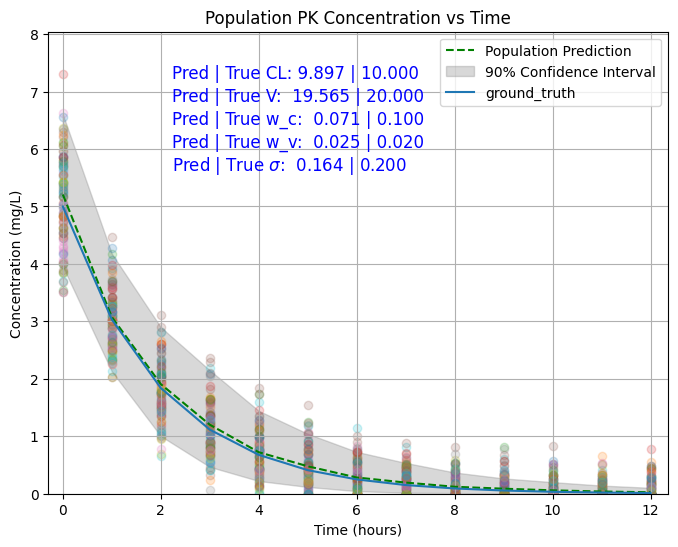

In [63]:
plot_CI(nn_train_pop)

## statistics method written previously, did not work well. Probably the wrong implementation.

In [64]:
warnings.simplefilter(action='ignore', category=RuntimeWarning)

# Define the objective function to minimize
def objective(params, df):
    cl, v, omega_cl, omega_v, sigma = params
    nll = 0  # Negative log-likelihood
    for patient in df['patient'].unique():
        patient_data = df[df['patient'] == patient]
        eta_cl = np.random.normal(0, np.sqrt(omega_cl))
        eta_v = np.random.normal(0, np.sqrt(omega_v))
        eps = np.random.normal(0, sigma)

        for index, row in patient_data.iterrows():
            time = row['time']
            observed = row['concentration']
            # Model prediction
            pred = (100 / (v * np.exp(eta_v))) * np.exp(
                        -((cl * np.exp(eta_cl)) / (v)) * time)
            # Update the negative log-likelihood (NLL)
            nll += ((observed - pred)**2) / (2 * sigma**2) \
                    + np.log(sigma * np.sqrt(2 * np.pi))

    return nll
# Initial parameter guesses
initial_params = [pred_cl, pred_vd, 0.1, 0.1, 0.1]  # [cl, v, omega_cl, omega_v, sigma]

# # Minimize the objective function
result_default = minimize(objective, initial_params, args=(df,),
              bounds=((0, None), (0, None), (0, None), (0, None), (0, None)))
result_no_grad = minimize(objective, initial_params, args=(df,),
                  method='Nelder-Mead',  # Gradient-free optimizer
                  options={'maxiter': 1000, 'disp': True})  # Increase iterations if needed

Estimated Parameters:
Clearance: 9.784330741227468
Volume: 19.523927050200196
Omega Clearance: 0.10000158098661102
Omega Volume: 0.10000143295224796
Sigma: 0.10000112223806441


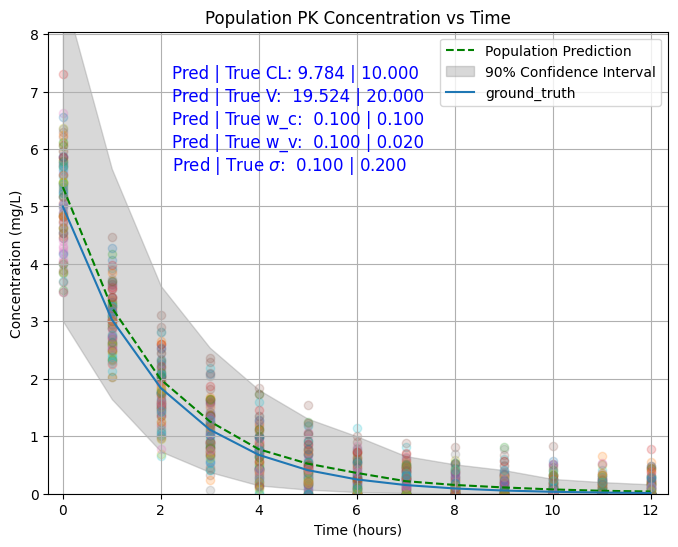

In [65]:
# Output the results
estimated_params = result_default.x
print("Estimated Parameters:")
print(f"Clearance: {estimated_params[0]}")
print(f"Volume: {estimated_params[1]}")
print(f"Omega Clearance: {estimated_params[2]}")
print(f"Omega Volume: {estimated_params[3]}")
print(f"Sigma: {estimated_params[4]}")
plot_CI(result_default.x)

Estimated Parameters:
Clearance: 9.784329414124905
Volume: 19.523925780915448
Omega Clearance: 0.10000000000158743
Omega Volume: 0.10500000000318088
Sigma: 0.0999999999989955


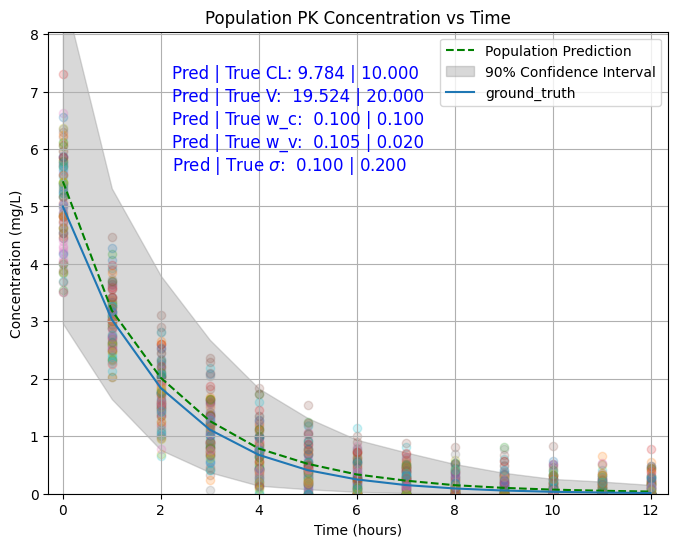

In [66]:
estimated_params = result_no_grad.x
print("Estimated Parameters:")
print(f"Clearance: {estimated_params[0]}")
print(f"Volume: {estimated_params[1]}")
print(f"Omega Clearance: {estimated_params[2]}")
print(f"Omega Volume: {estimated_params[3]}")
print(f"Sigma: {estimated_params[4]}")
plot_CI(result_no_grad.x)